# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCreated', 'LastSeen', 'DateCrawled'])
df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

(               Price  RegistrationYear          Power      Kilometer  \
 count  354369.000000     354369.000000  354369.000000  354369.000000   
 mean     4416.656776       2004.234448     110.094337  128211.172535   
 std      4514.158514         90.227958     189.850405   37905.341530   
 min         0.000000       1000.000000       0.000000    5000.000000   
 25%      1050.000000       1999.000000      69.000000  125000.000000   
 50%      2700.000000       2003.000000     105.000000  150000.000000   
 75%      6400.000000       2008.000000     143.000000  150000.000000   
 max     20000.000000       9999.000000   20000.000000  150000.000000   
 
        RegistrationMonth  NumberOfPictures     PostalCode  
 count      354369.000000          354369.0  354369.000000  
 mean            5.714645               0.0   50508.689087  
 std             3.726421               0.0   25783.096248  
 min             0.000000               0.0    1067.000000  
 25%             3.000000           

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Имеются пропуски в данных, разберемся с ними. 
Начнем с VehicleType

In [4]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [5]:
# заменим пропуски на "unknown"
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
unknown        37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [6]:
# проверим сколько пропусков в столбце 'FuelType'
df['FuelType'].isnull().sum()

32895

почти 10% пропусков, удалять их не стоит но заполнить предлагаю 'unknown'

In [7]:
df['FuelType'] = df['FuelType'].fillna('unknown')
df['FuelType'].value_counts()

petrol      216352
gasoline     98720
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [8]:
# проверим пропуски в NotRepaired
print(df['NotRepaired'].value_counts())
df['NotRepaired'].isnull().sum()

no     247161
yes     36054
Name: NotRepaired, dtype: int64


71154

то что этот показатель точно влияет на стоимость нам не следует удалять эти строки, но мы не можем все пропуски заменить на `no` или `yes`, по этому правельнее было бы заполнить пропуски значением 'unknown'

In [9]:
# используем метод ’bfill’
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')
df['NotRepaired'].isnull().sum()

0

In [10]:
# проверим пропуски в Gearbox
print(df['Gearbox'].value_counts())
df['Gearbox'].isnull().sum()

manual    268251
auto       66285
Name: Gearbox, dtype: int64


19833

In [11]:
# Заменим методом ’ffill’
df['Gearbox'] = df['Gearbox'].fillna(method='ffill')
df['Gearbox'].isnull().sum()

0

In [12]:
print(df['Model'].value_counts())
df['Model'].isnull().sum()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64


19705

Аналогично заполним пропуски в столбце `Model`

In [13]:
# Заменим методом ’ffill’
df['Model'] = df['Model'].fillna(method='ffill')
df['Model'].isnull().sum()

0

Хорошо, с пропусками разобрались.

Теперь вызывают сомнения сами данные в некоторых столбцах: в `RegistrationYear` значение года 1000 и 9999 не реальные, в столбце `Power` так жн значение 0 и 20000 не похожи на правдивые а столбец `NumberOfPictures` нам вообще не пригодится так как там все данные нулевые

<AxesSubplot:>

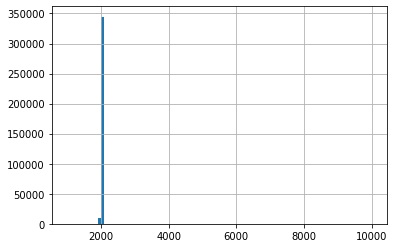

In [14]:
# посмотрим на распределение данных 'RegistrationYear'
df['RegistrationYear'].hist(bins=100, range=(1000, 9999))

<AxesSubplot:>

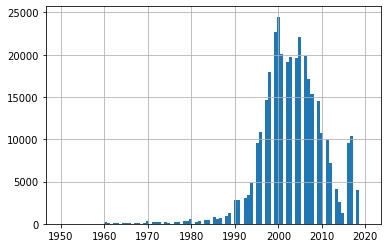

In [15]:
# посмотрим на данные в основном периоде
df['RegistrationYear'].hist(bins=100, range=(1950, 2020))

определим период от 1960 года до 2020, а остальные значения заменим средним так как их не так много, зато мы избавимся от выбросов что положительно влияет на обучаемость модели.

In [16]:
df.loc[(df['RegistrationYear'] <1960) | (df['RegistrationYear'] >2020),['RegistrationYear']] = df['RegistrationYear'].mean()
df['RegistrationYear'].describe()

count    354369.000000
mean       2003.151705
std           7.221255
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

0   2016-03-24 11:52:17
1   2016-03-24 10:58:45
2   2016-03-14 12:52:21
3   2016-03-17 16:54:04
4   2016-03-31 17:25:20
5   2016-04-04 17:36:23
6   2016-04-01 20:48:51
7   2016-03-21 18:54:38
8   2016-04-04 23:42:13
9   2016-03-17 10:53:50
Name: DateCrawled, dtype: datetime64[ns]

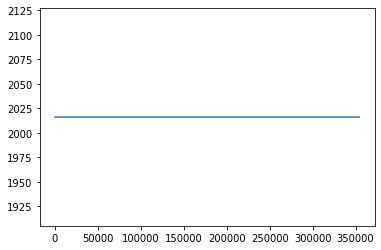

In [17]:
# Проверим данные столбца `DateCrawled`
df['DateCrawled'].dt.year.plot()
df['DateCrawled'].head(10)

Даты сканирования в 2016 году. Скорее всего этот параметр ни как не повлияет на обучаемость модели, удалим его.

Аналогично преобразуем данные в столбце `Power`

<AxesSubplot:>

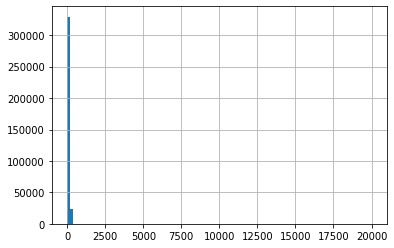

In [18]:
# посмотрим на распределение данных 'Power'
df['Power'].hist(bins=100, range=(0, 20000))

<AxesSubplot:>

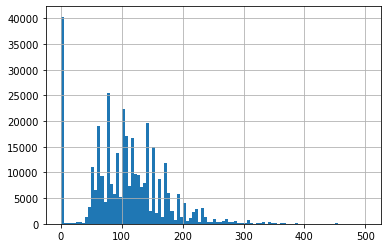

In [19]:
# посмотрим на данные в основном периоде
df['Power'].hist(bins=100, range=(0, 500))

Стоит нулевые значения убрать из данных так как это скорее всего не реалистично и негативно повлияет на обучаемость модель. Вероятнее всего будет оптимальным заменить их на среднее значение. Не исключается что есть модели машин с большой мощьностью и логично что их мало.

In [20]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unknown,1993.0,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011.0,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004.0,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001.0,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008.0,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [21]:
df.loc[df['Power'] < 40]['Power'] = df['Power'].mean()
df['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [22]:
# удалим столбцы `NumberOfPictures`, 'DateCrawled', 'DateCreated', 'LastSeen'
df=df.drop(columns = ['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen'],axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              354369 non-null  int64  
 1   VehicleType        354369 non-null  object 
 2   RegistrationYear   354369 non-null  float64
 3   Gearbox            354369 non-null  object 
 4   Power              354369 non-null  int64  
 5   Model              354369 non-null  object 
 6   Kilometer          354369 non-null  int64  
 7   RegistrationMonth  354369 non-null  int64  
 8   FuelType           354369 non-null  object 
 9   Brand              354369 non-null  object 
 10  NotRepaired        354369 non-null  object 
 11  PostalCode         354369 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 32.4+ MB


Для работы алгоритмов обучения необходимо кодировать данные, которые представлены просто в виде текста

In [23]:

encoder = OrdinalEncoder()
columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
df_ordinal = pd.DataFrame(df)
df_ordinal[columns] = encoder.fit_transform(df_ordinal[columns])

df_ordinal.head()


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,7.0,1993.0,1.0,0,116.0,150000,0,6.0,38.0,1.0,70435
1,18300,2.0,2011.0,1.0,190,116.0,125000,5,2.0,1.0,2.0,66954
2,9800,6.0,2004.0,0.0,163,117.0,125000,8,2.0,14.0,1.0,90480
3,1500,5.0,2001.0,1.0,75,116.0,150000,6,6.0,38.0,0.0,91074
4,3600,5.0,2008.0,1.0,69,101.0,90000,7,2.0,31.0,0.0,60437


In [24]:
# кодирование методом OHE для Линейной регрессии
df_ordinal_ohe = df.copy()
df_ordinal_ohe = pd.get_dummies(df_ordinal_ohe, columns=columns)
df_ordinal_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_unknown,NotRepaired_yes
0,480,1993.0,0,150000,0,70435,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,18300,2011.0,190,125000,5,66954,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004.0,163,125000,8,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001.0,75,150000,6,91074,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,3600,2008.0,69,90000,7,60437,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Обучение моделей

Проверим работу 3-х моделей: `Линейной регрессии`, `Дерева решений` и `Случайного леса`

In [25]:


# разделим данные на тренировочные и проверочные

train, valid = train_test_split(df_ordinal_ohe, test_size=0.25, random_state=12345)

# разделим данные на обучающую и целевую
features_train = train.drop(['Price'], axis=1)
target_train = train['Price']
features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price']

# проверим модель Линейной регрессии
model_LR = LinearRegression()
model_LR.fit(features_train, target_train)
predictions = model_LR.predict(features_valid)
print('МАЕ:', mean_absolute_error(target_valid, predictions))
print('RMSE:', mean_squared_error(target_valid, predictions, squared= False))
scores = cross_val_score(model_LR, features_train, target_train, scoring = 'neg_root_mean_squared_error', cv=5)
print('Кросс валидация:', scores.sum()/len(scores))
del df_ordinal_ohe

МАЕ: 2010.3033642611856
RMSE: 2888.033010423498
Кросс валидация: -2886.4498823603813


In [26]:
# модель Дерева решений
train, valid = train_test_split(df_ordinal, test_size=0.25, random_state=12345)

# разделим данные на обучающую и целевую
features_train = train.drop(['Price'], axis=1)
target_train = train['Price']
features_valid = valid.drop(['Price'], axis=1)
target_valid = valid['Price']

model_DTR = DecisionTreeRegressor(random_state=12345)
model_DTR.fit(features_train, target_train)
#predictions = model_DTR.predict(features_valid)
#print('МАЕ:', mean_absolute_error(target_valid, predictions))
#print('RMSE', mean_squared_error(target_valid, predictions, squared= False))
scores = cross_val_score(model_DTR, features_train, target_train, scoring = 'neg_root_mean_squared_error', cv=5)
print('Кросс валидация:', scores.sum()/len(scores))

Кросс валидация: -2406.567499795313


In [27]:
# модель Случайного леса
model_RFR = RandomForestRegressor(random_state=12345)
model_RFR.fit(features_train, target_train)
#predictions = model_RFR.predict(features_valid)
#print('МАЕ:', mean_absolute_error(target_valid, predictions))
#print('RMSE', mean_squared_error(target_valid, predictions, squared= False))
scores = cross_val_score(model_RFR, features_train, target_train, scoring = 'neg_root_mean_squared_error', cv=3)
print('Кросс валидация:', scores.sum()/len(scores))

Кросс валидация: -1776.2752046088835


Модель случайного леса показала лучший результат

### проверка гиперпараметров

В линейной регрессии гиперпараметры особо не влияют на качество модели по этому проверим Дерево решений

In [44]:
%%time
max_depth = 0
cvs = -10000
for depth in range(10, 20):
    model_DTR = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model_DTR.fit(features_train, target_train)
    #predictions = model_DTR.predict(features_valid)
    score = cross_val_score(model_DTR, features_train, target_train, scoring = 'neg_root_mean_squared_error', cv=3).mean()
    
    if score > cvs:
        max_depth = depth
        cvs = score
print("Дерево решений с лучшей глубиной max_depth =", max_depth, "кроссвалидация модели: ", cvs)


Дерево решений с лучшей глубиной max_depth = 12 кроссвалидация модели:  -2116.240170532024
CPU times: user 47 s, sys: 0 ns, total: 47 s
Wall time: 47 s


С гиперпараметрами глубины дерева 12 модель дает лучший результат

In [45]:
%%time
# Случайный лес
#scorer = make_scorer('neg_root_mean_squared_error')
param_grid = {'max_depth': range(20, 22), 'n_estimators': [50, 60]}
model_RFR = RandomForestRegressor(random_state=12345)
search = GridSearchCV(model_RFR, param_grid, cv=5, scoring = 'neg_root_mean_squared_error')
search.fit(features_train, target_train)
print('Лучшее значение для случайного леса: {} при значениях гиперпараметров: {}'.format(-search.best_score_, search.best_params_))


Лучшее значение для случайного леса: 1760.10156096832 при значениях гиперпараметров: {'max_depth': 21, 'n_estimators': 60}
CPU times: user 21min 25s, sys: 479 ms, total: 21min 25s
Wall time: 21min 33s


**Лучшее значение показателя для случайного леса: 1760, что лучше показывает подбор параметров. Значение гиперпараметров: 
- 'max_depth': 21,
- 'n_estimators': 60

Время работы модели: 21min 33s

In [49]:
# Проверка CatBoostRegressor
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# разделим данные на тренировочные и проверочные для CBR
train_cbr, valid_cbr = train_test_split(df, test_size=0.25, random_state=12345)
# разделим данные на обучающую и целевую
features_train_cbr = train_cbr.drop(['Price'], axis=1)
target_train_cbr = train_cbr['Price']
features_valid_cbr = valid_cbr.drop(['Price'], axis=1)
target_valid_cbr = valid_cbr['Price'] 
features_train_cbr[cat_features] = features_train_cbr[cat_features].astype('category')
features_valid_cbr[cat_features] = features_valid_cbr[cat_features].astype('category')
model_CBR = CatBoostRegressor(loss_function="RMSE", iterations=150)
print('Обучение...')
model_CBR.fit(features_train_cbr, target_train_cbr, cat_features=cat_features, verbose=10)
print('Расчет...')
#predict_valid = model_CBR.predict(features_valid_cbr)
scores = cross_val_score(model_CBR, features_train, target_train, scoring = 'neg_root_mean_squared_error', cv=3).mean()

print('Кроссвалидация модели:', scores)

Обучение...
Learning rate set to 0.462478
0:	learn: 3346.5425558	total: 280ms	remaining: 41.7s
10:	learn: 2050.8375440	total: 2.78s	remaining: 35.1s
20:	learn: 1959.8721124	total: 5.16s	remaining: 31.7s
30:	learn: 1916.4038366	total: 7.62s	remaining: 29.2s
40:	learn: 1879.5725237	total: 10.1s	remaining: 26.8s
50:	learn: 1852.4548144	total: 12.6s	remaining: 24.4s
60:	learn: 1832.3738214	total: 15s	remaining: 21.9s
70:	learn: 1814.2112753	total: 17.5s	remaining: 19.5s
80:	learn: 1801.4678074	total: 20.1s	remaining: 17.1s
90:	learn: 1789.8207713	total: 22.7s	remaining: 14.7s
100:	learn: 1780.8234008	total: 25.2s	remaining: 12.2s
110:	learn: 1773.2585329	total: 27.7s	remaining: 9.75s
120:	learn: 1765.5540959	total: 30.3s	remaining: 7.26s
130:	learn: 1757.5348714	total: 32.8s	remaining: 4.76s
140:	learn: 1748.8577101	total: 35.3s	remaining: 2.25s
149:	learn: 1740.5121876	total: 37.6s	remaining: 0us
Расчет...
Learning rate set to 0.433779
0:	learn: 3415.9785391	total: 58.6ms	remaining: 8.73s

**Кроссвалидация модели: -1815**

In [51]:
# LGBMRegressor
print('Обучение...')
model_LGBMR = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.05,n_estimators=20)
model_LGBMR.fit(features_train, target_train, eval_metric='rmse')
print('Расчет...')
#predict_valid = model_LGBMR.predict(features_valid, num_iteration=model_LGBMR.best_iteration_)
scores = cross_val_score(model_LGBMR, features_train, target_train, scoring = 'neg_root_mean_squared_error', cv=3)
print('Кроссвалидация модели:', scores.mean())

Обучение...
Расчет...
Кроссвалидация модели: [-2748.26310958 -2736.12760565 -2734.05258615]


**Кроссвалидация модели: -2739.48**
​

## Анализ моделей

In [55]:
estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    'max_depth': [2, 7, 15, 20],
    'n_estimators': [20, 40, 100],
    'learning_rate': [0.01, 0.1, 0.5]
    }
print('Подбор параметров...')
model_LGBMR = GridSearchCV(estimator, param_grid, scoring = 'neg_root_mean_squared_error')


Подбор параметров...


In [56]:
%%time
print('Обучение...')
model_LGBMR.fit(features_train, target_train)
print('Лучшие параметры модели:', model_LGBMR.best_params_)
print('Качество:', model_LGBMR.best_score_)

Обучение...
Лучшие параметры модели: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100}
Качество: -1811.4179196266462
CPU times: user 1h 1s, sys: 22.2 s, total: 1h 24s
Wall time: 1h 48s


In [58]:
%%time
print('Расчет...')
#LGBMR = lgb.LGBMRegressor(num_leaves=31)
predict_valid = model_LGBMR.predict(features_valid)
print('RMSE', mean_squared_error(target_valid, predict_valid, squared= False))

Расчет...
RMSE 1805.7696646323197
CPU times: user 757 ms, sys: 3.8 ms, total: 760 ms
Wall time: 768 ms


Лучшие параметры
- 'learning_rate': 0.5, 
- 'max_depth': 7, 
- 'n_estimators': 100

Качество: -1811.4179

Время обучения: 1h 48s

Время расчета: 768 ms

**Конечно качество модели лучше, но мы тераяем время на обучение модели.**

In [59]:
parameters = {'depth'         : [2, 7, 15, 20],
              'learning_rate' : [0.01, 0.1, 0.5],
              'iterations'    : [20, 40, 100]
              }
print('Подбор параметров...')
grid_cbr = GridSearchCV(estimator=model_CBR,
                        param_grid = parameters,
                        cv = 2, n_jobs=-1,
                        scoring = 'neg_root_mean_squared_error')


Подбор параметров...


In [60]:
%%time
print('Обучение...')
grid_cbr.fit(features_train_cbr, target_train_cbr, cat_features=cat_features, verbose=10)
print("Лучшая модель",grid_cbr.best_estimator_)
print("Качество",grid_cbr.best_score_)
print("Лучшие параметры",grid_cbr.best_params_)

Обучение...
0:	learn: 4490.5942446	total: 66.3ms	remaining: 1.26s
10:	learn: 4304.4857892	total: 618ms	remaining: 506ms
19:	learn: 4156.9030111	total: 1.09s	remaining: 0us
0:	learn: 4490.6647234	total: 66.9ms	remaining: 1.27s
10:	learn: 4303.6966490	total: 609ms	remaining: 498ms
19:	learn: 4156.2046105	total: 1.06s	remaining: 0us
0:	learn: 4312.3437559	total: 65.5ms	remaining: 1.25s
10:	learn: 3241.7277310	total: 768ms	remaining: 628ms
19:	learn: 2862.5368637	total: 1.22s	remaining: 0us
0:	learn: 4311.8122007	total: 64.5ms	remaining: 1.23s
10:	learn: 3245.3998657	total: 605ms	remaining: 495ms
19:	learn: 2864.3641128	total: 1.06s	remaining: 0us
0:	learn: 3664.7295394	total: 65.1ms	remaining: 1.24s
10:	learn: 2418.7307550	total: 601ms	remaining: 491ms
19:	learn: 2279.2140933	total: 1.05s	remaining: 0us
0:	learn: 3661.7593536	total: 64.4ms	remaining: 1.22s
10:	learn: 2411.1741332	total: 606ms	remaining: 496ms
19:	learn: 2276.0719168	total: 1.05s	remaining: 0us
0:	learn: 4490.5942446	total

In [62]:
%%time
print('Расчет...')
predict_valid_cbr = grid_cbr.predict(features_valid_cbr)
print('RMSE', mean_squared_error(target_valid_cbr, predict_valid_cbr, squared= False))

Расчет...
RMSE 1768.0143886143078
CPU times: user 204 ms, sys: 0 ns, total: 204 ms
Wall time: 202 ms



- Качество -1804.065410944886
-  Лучшие параметры depth': 15, 
- iterations: 100, 
- learning_rate: 0.1

- Wall time: 25min 39s

Модель LGBMRegressor
модель CatBoostRegressor

In [63]:
result=pd.DataFrame([{'Точночть':'-1811.4179', 'время обучения':'1h 48s', 'время расчета':'768 ms'}
                     , {'Точночть':'-1804.0654', 'время обучения':'25min 24s', 'время расчета':'202 ms'}],
                    index=['LGBMRegressor', 'CatBoostRegressor'])
display(result)

,Точночть,время обучения,время расчета
LGBMRegressor,-1811.4179,1h 48s,768 ms
CatBoostRegressor,-1804.0654,25min 24s,202 ms


**вывод**
Мы проверили три модели расчета вероятной стоимости автомомбиля и выяснили что модель Случайного леса наиболее точная.
Однако проверив работу алгоритма путем градиентного бустинга  Мы выяснили что работа алгоритма `LGBMRegressor` дает лучший результат и по точности и по времени расчета. Его и предлагаем в качестве модели расчета стоимости.


Модель `LGBMRegressor` показала лучший результат качества и время работы модели быстрее чем `CatBoostRegressor`.
С параметрами: 

depth': 15,

iterations: 100,

learning_rate: 0.1

эта модель будет давать наиболее точные предсказания стоимости.

